# Charging the data

## 1. Import libraries

In [135]:
import random

import numpy as np

import pandas as pd

from skimage import filters, io, img_as_ubyte
from skimage.filters import median
from skimage.morphology import disk

from scipy.interpolate import interp1d, RegularGridInterpolator,make_interp_spline
from scipy.integrate import simpson
from scipy.ndimage import convolve1d

from astropy.io import fits
from astropy.convolution import convolve

from sklearn.model_selection import train_test_split

import torch
from torchvision import transforms

import os

from tqdm import tqdm 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable


from pathlib import Path

In [136]:
plt.rcParams.update({
  'axes.titlesize': 'x-large',  # heading 1
  'axes.labelsize': 'large',   # heading 2
  'xtick.labelsize': 'medium',         # fontsize of the ticks
  'ytick.labelsize': 'medium',         # fontsize of the ticks
  'font.family': 'serif',        # Font family
  'text.usetex': False,          # Do not use LaTeX for text rendering
  'figure.figsize': (10, 8),     # Default figure size
  'savefig.dpi': 300,            # High resolution for saving figures
  'savefig.format': 'png',       # Default format for saving figures
  'legend.fontsize': 'large',  # Font size for legends
  'lines.linewidth': 2,          # Line width for plots
  'lines.markersize': 8,         # Marker size for plots,
  'axes.formatter.useoffset': False,  # Disable offset
  'axes.formatter.use_mathtext': True,  # Use scientific notation
  'axes.formatter.limits': (-3, 4),  # Use scientific notation for values over 10^2
  'axes.labelsize': 'large',     # Font size for axes labels
  'figure.titlesize': 'xx-large' # Font size for suptitles (heading 1)
})

## 2. Charge the data

### 2.1 Charge the raw data

First let's define the path to the data and use a testing file. Also, some quantities useful for the dimensiones to be treated later in the code.

In [137]:
images_output = Path("../thesis_images")
if not os.path.exists(images_output):
    os.makedirs(images_output)

In [138]:
ptm = Path("/scratchsan/observatorio/juagudeloo/data")
filename = "080000"

nlam = 300 #this parameter is useful when managing the Stokes parameters #wavelenght interval - its from 6300 amstroengs in steps of 10 amstroengs
nx = 480
ny = 480 #height axis
nz = 256

Charge the data corresponding to temperature, density, magnetic field and velocity

In [139]:
print(f"""
        ######################## 
        Reading {filename} MuRAM data...
        ######################## 
              """)

geom_path = ptm / "geom_height"
print("Charging temperature ...")
mtpr = np.load(geom_path / f"mtpr_{filename}.npy").flatten()
print("mtpr shape:", mtpr.shape)

print("Charging magnetic field vector...")
mbxx = np.load(geom_path / f"mbxx_{filename}.npy")
mbyy = np.load(geom_path / f"mbyy_{filename}.npy")
mbzz = np.load(geom_path / f"mbzz_{filename}.npy")

coef = np.sqrt(4.0*np.pi) #cgs units conversion300

mbxx=mbxx*coef
mbyy=mbyy*coef
mbzz=mbzz*coef
print("mbxx shape:", mbxx.shape)
print("mbyy shape:", mbyy.shape)
print("mbzz shape:", mbzz.shape)

print("Charging density...")
mrho = np.load(geom_path / f"mrho_{filename}.npy")
print("mrho shape:", mrho.shape)

print("Charge velocity...")
mvzz = np.load(geom_path / f"mvzz_{filename}.npy")
print("mvzz shape:", mbzz.shape)

mvzz = mvzz/mrho

mrho = np.log10(mrho)

muram_box = np.stack([mtpr, mrho, mvzz, mbxx, mbyy, mbzz], axis=-1)
muram_box = muram_box.reshape(nx, nz, ny, 6)
muram_box = np.transpose(muram_box, (0, 2, 1, 3))
print(f"""
        ######################## 
        Finished!
        ######################## 
              """)

del mtpr, mrho, mbxx, mbyy, mbzz, mvzz


        ######################## 
        Reading 080000 MuRAM data...
        ######################## 
              
Charging temperature ...


mtpr shape: (58982400,)
Charging magnetic field vector...
mbxx shape: (58982400,)
mbyy shape: (58982400,)
mbzz shape: (58982400,)
Charging density...
mrho shape: (58982400,)
Charge velocity...
mvzz shape: (58982400,)

        ######################## 
        Finished!
        ######################## 
              


For the vertical representation, we'll take the mean value for each surface.

In [140]:
from scipy.interpolate import make_interp_spline

domain_heights = np.array(range(0, 256)) * 10
mean_T = muram_box[...,0].mean(axis = (0,1)) 
T_indices = np.argsort(mean_T)
mean_T = mean_T[T_indices]
domain_heights = domain_heights[T_indices]

Teff = 5780
height_T_func = make_interp_spline(mean_T, domain_heights, k=3)
height_Teff = height_T_func(Teff)
print(f"Height at Teff = {height_Teff} km")

domain_heights = domain_heights - height_Teff
domain_heights = np.sort(domain_heights)




Height at Teff = 1897.479302927621 km


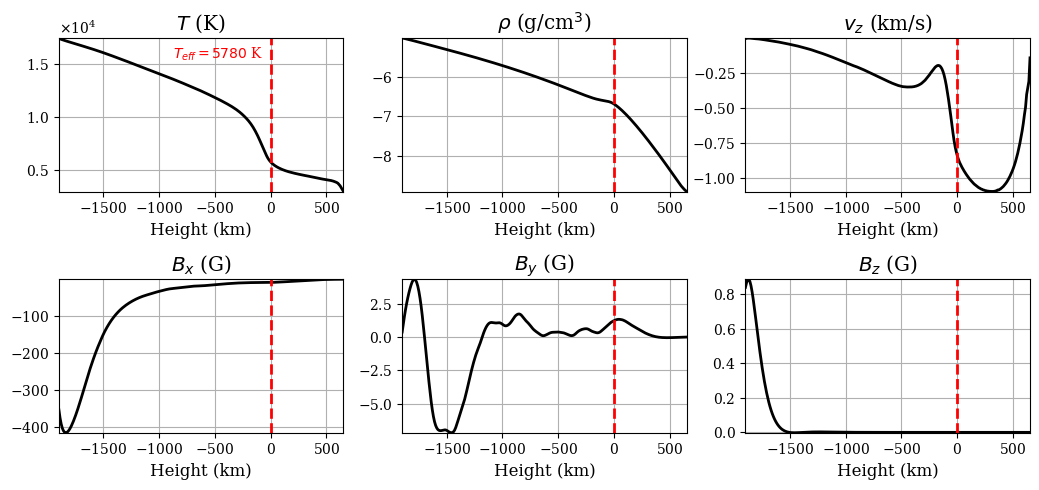

In [141]:
fig, ax = plt.subplots(2, 3, figsize=(3*3.5, 2*2.5))

quantities = [
    (0, r"$T$", "K", "inferno"),
    (1, r"$\rho$", r"g/cm$^3$", "summer"),
    (2, r"$v_z$", "km/s", "bwr_r"),
    (3, r"$B_x$", "G", "PuOr"),
    (4, r"$B_y$", "G", "PuOr"),
    (5, r"$B_z$", "G", "PiYG"),
]


for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[...,param_idx].mean(axis = (0,1)) 
  if title in [r"$v_z$"]:  # Convert from cm/s to km/s
    data /= 1e5
    
  iax = ax[i // 3, i % 3]
  
  iax.plot(domain_heights, data, "k")
  iax.axvline(x=0, color='red', linestyle='--')
  if title == r"$T$":
      iax.text(0.4, 0.95, r'$T_{eff} = 5780$ K', color='red', transform=iax.transAxes, verticalalignment='top')
  iax.set_xlabel("Height (km)")
  iax.set_title(f"{title} ({unit})")
  iax.set_xlim(domain_heights.min(), domain_heights.max())
  iax.grid(True)
  iax.set_ylim(data.min(), data.max())
plt.tight_layout(w_pad=1.0, h_pad=1.0)
fig.savefig(images_output / "muram_box_mean_profile_geom_height.png", dpi=300)

plt.show()


Let's plot them to check their distribution along height and over a surface

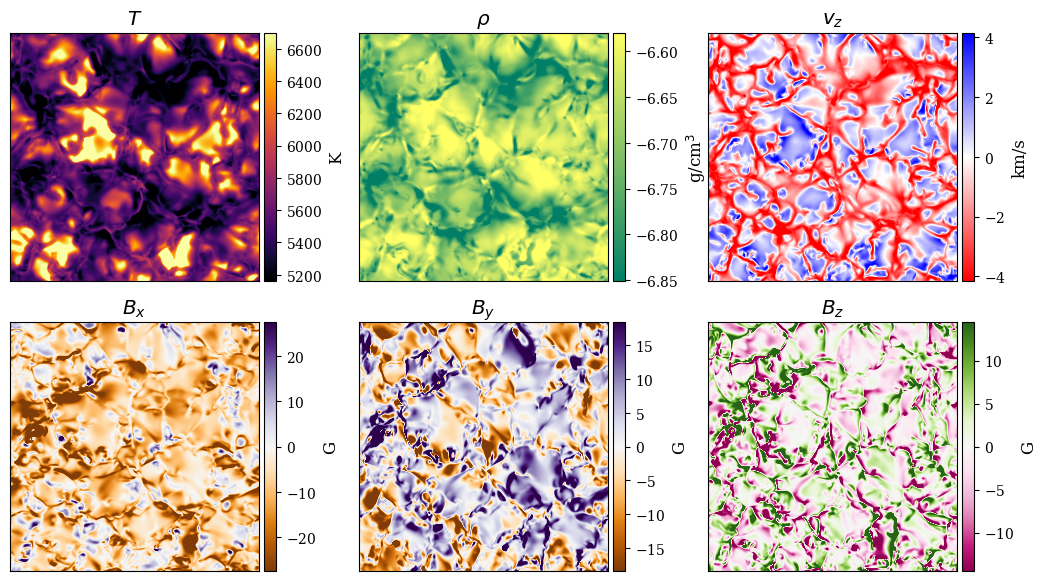

In [142]:
height_pix = 190
fig, ax = plt.subplots(2, 3, figsize=(3*3.5, 2*3))
for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[...,param_idx][:, :, height_pix]
  if title in [r"$v_x$", r"$v_y$", r"$v_z$"]:  # Convert from cm/s to km/s
    data /= 1e5
  if title in [r"$B_x$", r"$B_z$",r"$B_y$", r"$v_z$"]:  # Magnetic field components and velocity need symmetric colorbars
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
    vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
  else:
    # Calculate quantiles for colorbar limits based on original data
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = orig_q5
    vmax = orig_q95
  im = ax[i // 3, i % 3].imshow(data, cmap = cmap, vmin = vmin, vmax = vmax)
  ax[i // 3, i % 3].set_title(title)
  ax[i // 3, i % 3].set_xticks([])
  ax[i // 3, i % 3].set_yticks([])
  divider = make_axes_locatable(ax[i // 3, i % 3])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax, label=unit)
plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "muram_box_fixed_geom_height.png", dpi=300)

plt.show()

In [143]:
first_positive_index = np.argmax(domain_heights > 0)
print(first_positive_index)

190


### 2.2 Optical Depth Stratification

In [144]:
# Load the pressure
eos = np.fromfile(os.path.join(geom_path,  f"eos.{filename}"), dtype=np.float32)
eos = eos.reshape((2, nx, nz, ny), order = "C")
mpre = eos[1]
mpre = np.moveaxis(mpre, 1, 2)  # Pressure array to be used in the calculation of the optical depth
del eos
mpre.shape

(480, 480, 256)

In [145]:
 # Upload the opacity data
tab_T = np.array([3.32, 3.34, 3.36, 3.38, 3.40, 3.42, 3.44, 3.46, 3.48, 3.50,
                3.52, 3.54, 3.56, 3.58, 3.60, 3.62, 3.64, 3.66, 3.68, 3.70,
                3.73, 3.76, 3.79, 3.82, 3.85, 3.88, 3.91, 3.94, 3.97, 4.00,
                4.05, 4.10, 4.15, 4.20, 4.25, 4.30, 4.35, 4.40, 4.45, 4.50,
                4.55, 4.60, 4.65, 4.70, 4.75, 4.80, 4.85, 4.90, 4.95, 5.00,
                5.05, 5.10, 5.15, 5.20, 5.25, 5.30]) #log(T) in K

tab_p = np.array([-2., -1.5, -1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5,
                3., 3.5, 4., 4.5, 5., 5.5, 6., 6.5, 7., 7.5, 8.]) #log(P) in dyne/cm^2

df_kappa = pd.read_csv('../csv/kappa.0.dat', sep='\s+', header=None)
df_kappa.columns = ["Temperature index", "Pressure index", "Opacity value"]
temp_indices = df_kappa["Temperature index" ].unique()
press_indices = df_kappa["Pressure index"].unique()
opacity_values = df_kappa.pivot(index = "Pressure index", columns = "Temperature index", values = "Opacity value").values

Tk = tab_T[temp_indices]
Pk = tab_p[press_indices]
K = opacity_values

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2773393/2204471890.py:12: SyntaxWarning: invalid escape sequence '\s'
  df_kappa = pd.read_csv('../csv/kappa.0.dat', sep='\s+', header=None)


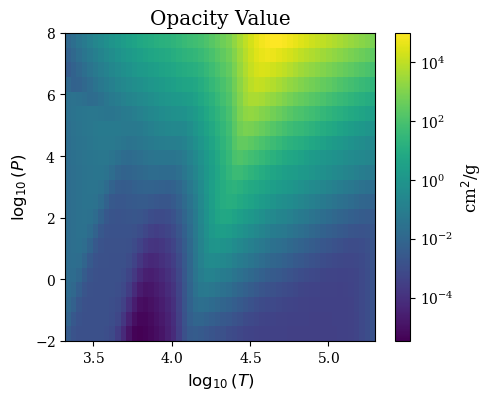

In [146]:
fig, ax = plt.subplots(figsize=(5, 4))
# Plot the 2D colormap with log normalization
cax = ax.imshow(K, cmap='viridis', aspect='auto', extent=[Tk.min(), Tk.max(), Pk.min(), Pk.max()], origin='lower', norm=LogNorm())

ax.set_xlabel(r'$\log_{10}(T)$')
ax.set_ylabel(r'$\log_{10}(P)$')
ax.set_title('Opacity Value')

fig.colorbar(cax, ax=ax, label=r'cm$^2$/g')
fig.savefig(images_output / "opacity_values.png")
plt.show()

In [147]:
def limit_values(data, min_val, max_val):
        new_data = np.clip(data, min_val+0.00001, max_val-0.00001)
        return new_data
                
T_log = np.log10(muram_box[..., 0]) 
P_log = np.log10(mpre) 
T_log = limit_values(T_log, Tk.min(), Tk.max())
P_log = limit_values(P_log, Pk.min(), Pk.max())
PT_log = np.stack((P_log.flatten(), T_log.flatten()), axis=-1)


In [148]:
kappa_interp = RegularGridInterpolator((Pk,Tk), K, method="linear")

In [149]:
kappa_rho = np.zeros_like(muram_box[..., 0])
kappa_rho = kappa_interp(PT_log)
kappa_rho = kappa_rho.reshape(muram_box[...,0].shape)
kappa_rho = np.multiply(kappa_rho, muram_box[..., 1])

In [150]:
#Optical depth calculation
logtau_name = f"logtau_{filename}.npy"
if not os.path.exists(geom_path / logtau_name): #In case the optical depth has not been calculated yet
    tau = np.zeros_like(kappa_rho)
    dz = 1e6 # 10 km -> 1e6 cm
    tau[:,:,nz-1] = 1e-5

    print("Calculating optical depth...")
    for iz in tqdm(range(1,nz)):
        for ix in range(nx):
            for iy in range(ny):
                kpz = kappa_rho[ix,iy,nz-1-iz:]
                tau[ix,iy,nz-1-iz] = simpson(y = kpz, 
                                    dx = dz)
                
    muram_logtau = np.log10(tau)
    np.save(geom_path / logtau_name, muram_logtau)
    
else: #For visualization is better to load the optical depth values from the file for fast demonstration
    muram_logtau = np.load(geom_path / logtau_name)

In [151]:
#New logtau nodes
new_logtau = np.linspace(-2.5, 0, 20)
n_logtau = new_logtau.shape[0]

In [152]:
def logtau_mapper(orig_arr: np.ndarray, 
    corresp_logtau: np.ndarray,
    new_logtau: np.ndarray,
    ) -> np.ndarray:
        """
        Function for mapping the quantities distribution from geometrical height to optical depth.
        Args:
            orig_arr(np.ndarray): Original array distributed along geometrical height to be mapped.
            corresp_logtau(np.ndarray): Distribution of optical depth for the original array.
            new_logtau(np.ndarray): Array of the new optical depth measurement of height for the mapping
        Returns:
            (np.ndarray) Array containing the mapped quantity to the new distribution on optical depth.
        """
        
        logtau_mapper = interp1d(x = corresp_logtau, y = orig_arr)
        new_arr = logtau_mapper(new_logtau)
        return new_arr

In [153]:
#Pixel by pixel iteration

#1. Atmospheric quantities iteration
atm_to_logtau = np.zeros((nx,ny,n_logtau,muram_box.shape[-1]))
for imur in range(muram_box.shape[-1]):
    
    # Check if the file exists
    #2. Pixel iteration
    geom_atm = muram_box[..., imur]
    new_muram_quantity = np.zeros((nx, ny, n_logtau))

    for ix in tqdm(range(nx)):
        for iy in range(ny):
            # Create and apply interpolation function directly
            mapper = interp1d(
                x=muram_logtau[ix, iy, :], 
                y=muram_box[ix, iy, :, imur], 
                kind="linear", 
                bounds_error=False, 
                fill_value="extrapolate"
            )
            new_muram_quantity[ix, iy, :] = mapper(new_logtau)
    atm_to_logtau[...,imur] = new_muram_quantity
muram_box = atm_to_logtau



  9%|▉         | 42/480 [00:00<00:06, 68.88it/s]

100%|██████████| 480/480 [00:06<00:00, 68.65it/s]


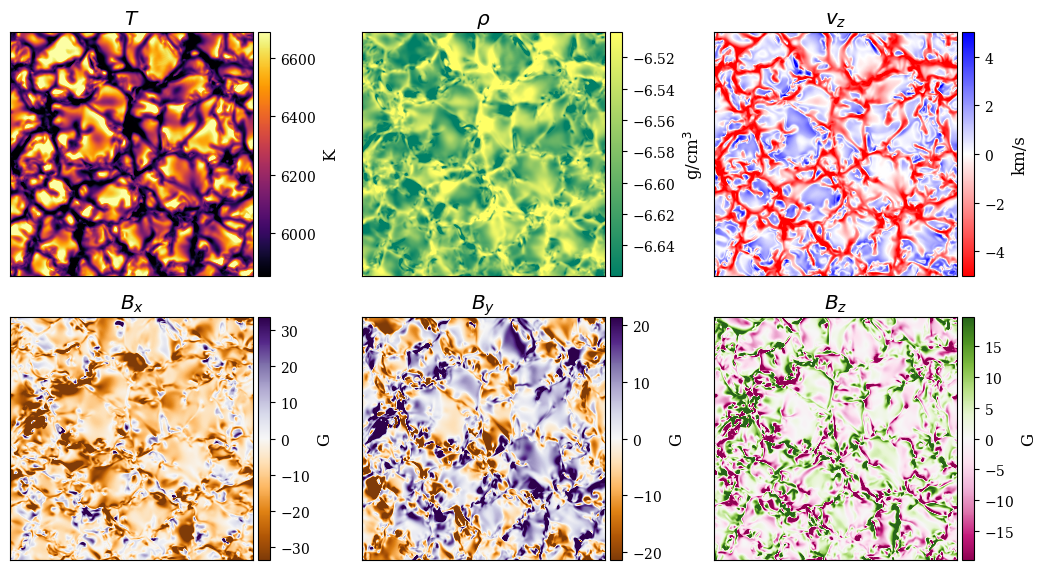

In [154]:
tau_pix = -1
fig, ax = plt.subplots(2, 3, figsize=(3*3.5, 2*3))
for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[...,param_idx][:, :, tau_pix]
  if title in [r"$v_x$", r"$v_y$", r"$v_z$"]:  # Convert from cm/s to km/s
    data /= 1e5
  if title in [r"$B_x$", r"$B_z$",r"$B_y$", r"$v_z$"]:  # Magnetic field components and velocity need symmetric colorbars
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
    vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
  else:
    # Calculate quantiles for colorbar limits based on original data
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = orig_q5
    vmax = orig_q95
  im = ax[i // 3, i % 3].imshow(data, cmap = cmap, vmin = vmin, vmax = vmax)
  ax[i // 3, i % 3].set_title(title)
  ax[i // 3, i % 3].set_xticks([])
  ax[i // 3, i % 3].set_yticks([])
  divider = make_axes_locatable(ax[i // 3, i % 3])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax, label=unit)
plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "muram_box_fixed_od.png", dpi=300)

plt.show()

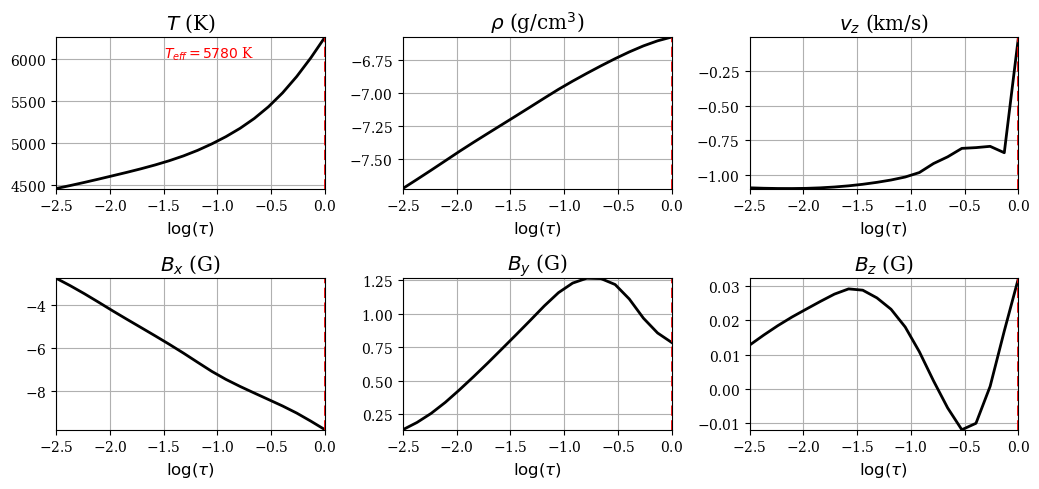

In [155]:
fig, ax = plt.subplots(2, 3, figsize=(3*3.5, 2*2.5))

for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[...,param_idx].mean(axis = (0,1)) 
  if title in [r"$v_z$"]:  # Convert from cm/s to km/s
    data /= 1e5
    
  iax = ax[i // 3, i % 3]
  
  iax.plot(new_logtau, data, "k")
  iax.axvline(x=0, color='red', linestyle='--')
  if title == r"$T$":
      iax.text(0.4, 0.95, r'$T_{eff} = 5780$ K', color='red', transform=iax.transAxes, verticalalignment='top')
  iax.set_xlabel(r"$\log(\tau)$")
  iax.set_title(f"{title} ({unit})")
  iax.set_xlim(new_logtau.min(), new_logtau.max())
  iax.grid(True)
  iax.set_ylim(data.min(), data.max())
plt.tight_layout(w_pad=1.0, h_pad=1.0)
fig.savefig(images_output / "muram_box_mean_profile_log_tau.png", dpi=300)

plt.show()

### 2.3 Non azimuth ambiguity components

As you may know, the magnetic field has an azimuth ambiguity in the sense that $B(\varphi) and B(\varphi + 180^\circ)$ influence the stokes parameters in the same way, then we may define some new components that are directly related to the stokes parameters, whose definition comes from the weak field aprosimation

\begin{equation}
\begin{split}
B_{\text{Q}} =& \text{sign}(B_x^2 - B_y^2) |B_x^2 - B_y^2|^{1/2}\\
B_{\text{U}} =& \text{sign}(B_x B_y) |B_x B_y|^{1/2}\\
B_{\text{V}} =& B_z
\end{split}
\end{equation}

Let's plot them to check their vertical and surface distribution.

In [156]:
modified_quantities = [
    (0, r"$T$", "K", "inferno"),
    (1, r"$\rho$", r"g/cm$^3$", "spring"),
    (2, r"$v_z$", "km/s", "bwr_r"),
    (3, r"$B_Q$", "G", "PRGn"),
    (4, r"$B_U$", "G",  "PRGn"),
    (5, r"$B_V$", "G", "PiYG"),
]


In [157]:
muram_box[:,3] = np.sign(muram_box[:,3]**2 - muram_box[:,4]**2)*np.sqrt(np.abs(muram_box[:,3]**2 - muram_box[:,4]**2))
muram_box[:,4] = np.sign(muram_box[:,3]*muram_box[:,4])*np.sqrt(np.abs(muram_box[:,3]*muram_box[:,4]))
muram_box[:,5] = muram_box[:,5]

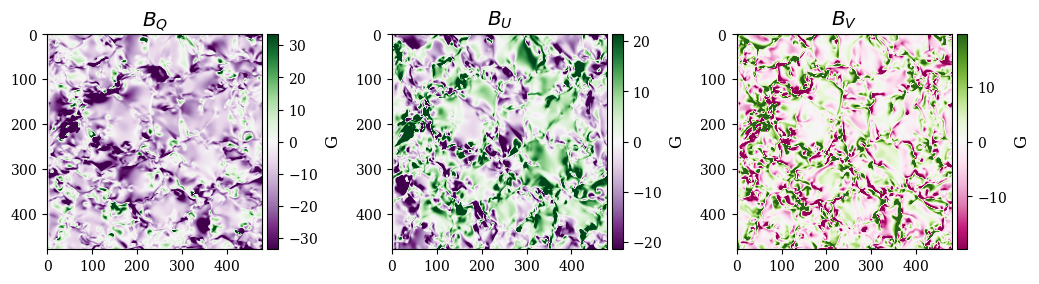

In [158]:
fig, ax = plt.subplots(1, 3, figsize=(3*3.5, 2*3))
for i, (param_idx, title, unit, cmap) in enumerate(modified_quantities):
  data = muram_box[...,tau_pix, param_idx]
  if title in [r"$B_Q$", r"$B_U$",r"$B_V$"]:  # Magnetic field components and velocity need symmetric colorbars
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
    vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
    im = ax[i % 3].imshow(data, cmap = cmap, vmin = vmin, vmax = vmax)
    ax[i % 3].set_title(title)
    divider = make_axes_locatable(ax[i % 3])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, label=unit)
plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "modified_mag_field_fixed_od.png", dpi=300)

plt.show()

## 3. Stokes parameters

### 3.1 Charge the Stokes parameters

Having the atmosphere magnitudes charged, we need to charge now the radiation information contained in the Stokes parameters generated for our simulation.

In [159]:
print("Charging Stokes vectors...")
stokes = np.load(ptm / "stokes" / f"{filename}_prof.npy")
print("Charged!")
print("stokes shape", stokes.shape)

Charging Stokes vectors...


Charged!
stokes shape (480, 480, 300, 4)


In [160]:
wl = (np.arange(300) * 0.01  + 6300.5) 

For further visualizations, let's select a random pixel to make spectral experiments.

test_x: 380, test_y: 350


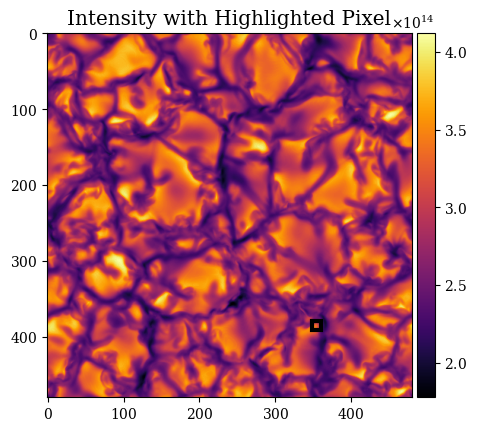

In [161]:
test_x = 380
test_y = 350

print(f"test_x: {test_x}, test_y: {test_y}")

fig, ax = plt.subplots(figsize=(5, 5))

# Plot the intensity (Stokes I) at the specified wavelength pixel
data = stokes[..., 0, 0]
im = ax.imshow(data, cmap='inferno')

# Add a thick black rectangle to highlight the selected pixel
rect = patches.Rectangle((test_y - 1.5, test_x - 1.5), 3*4, 3*4, linewidth=3, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

ax.set_title("Intensity with Highlighted Pixel")

plt.show()

### 3.2 Spectra normalization

In astronomical sciences, it is common practice to normalize all the presented spectra to the continuum so that you are able to visualize the general behaviour of the spectra independent of the instrument measuring it. For this, we will choose manually some continuum dots.

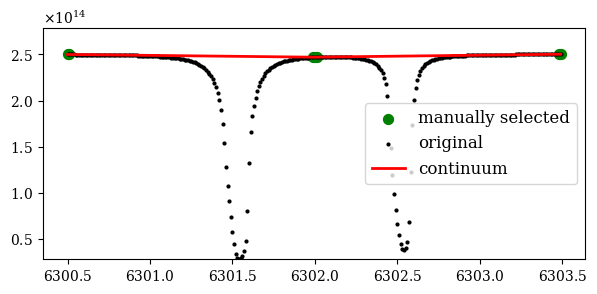

In [162]:
#Selection of the indices that we assume generally correspond to continuum in our data.
cont_indices = [0,1,int(len(wl)/2)-1,int(len(wl)/2),int(len(wl)/2)+1,-2,-1]


wl_cont_values = wl[cont_indices] #corresponding wavelength values to the selected continuum indices
cont_values = stokes[test_x, test_y,cont_indices,0] #corresponding intensity values to the selected continuum indices

cont_model = interp1d(wl_cont_values, cont_values, kind="linear") #Interpolation applied over the assumed continuum values

fig, ax = plt.subplots(figsize = (7,3))
ax.scatter(wl_cont_values, cont_values, label = "manually selected", color = "green", s = 50)
ax.scatter(wl, stokes[test_x, test_y, :, 0], label = "original", color = "black", s = 4)
ax.plot(wl, cont_model(wl), label="continuum", color = "red")
ymin = np.min(stokes[test_x, test_y,:,0])
ymax = np.max(stokes[test_x, test_y,:,0])
ax.set_ylim((ymin, ymax+ymin))
ax.legend()
fig.savefig(images_output / "continuum_interpolation.png", dpi=300)
plt.show()



Let's create a function for doing it independent of the size of our spectral cube for our respective surface.

In [163]:
def continuum_normalization(spectral_cube: np.ndarray, wl_array: np.ndarray) -> np.ndarray:
    """
    Function to normalize the spectral cube by continuum normalization.
    Args:
        spectral_cube(np.ndarray): Spectral cube to be normalized.
        wl_array(np.ndarray): Wavelength array.
    Returns:
        (np.ndarray) Normalized spectral
    """
    cont_indices = [0,1,int(len(wl_array)/2)-1,int(len(wl_array)/2),int(len(wl_array)/2)+1,-2,-1]

    wl_cont_values = wl_array[cont_indices]
    # Vectorized interpolation for speedup
    # cont_values = spectral_cube[:, :, cont_indices, 0].mean(axis = 2).flatten().mean()  # corresponding intensity values to the selected continuum indices
    # cont_model = interp1d(wl_cont_values, cont_values, kind="linear", axis=2)  # Interpolation applied over the assumed continuum values
    I_c =  spectral_cube[:, :, cont_indices, 0].mean(axis = 2).flatten().mean()
    # Apply the normalization
    norm_spectral_cube = np.zeros_like(spectral_cube)
    #mean_continuum_image = cont_model(wl_array).mean(axis=2)
    mean_continuum_image = spectral_cube[:, :, cont_indices, 0].mean(axis = 2)
    for i in range(spectral_cube.shape[-1]):
        norm_spectral_cube[..., i] = spectral_cube[..., i]/ I_c

    mean_continuum_image /= I_c
    return norm_spectral_cube, mean_continuum_image

In [164]:
norm_stokes, mean_continuum = continuum_normalization(stokes, wl)
old_mean_continuum = mean_continuum.copy()

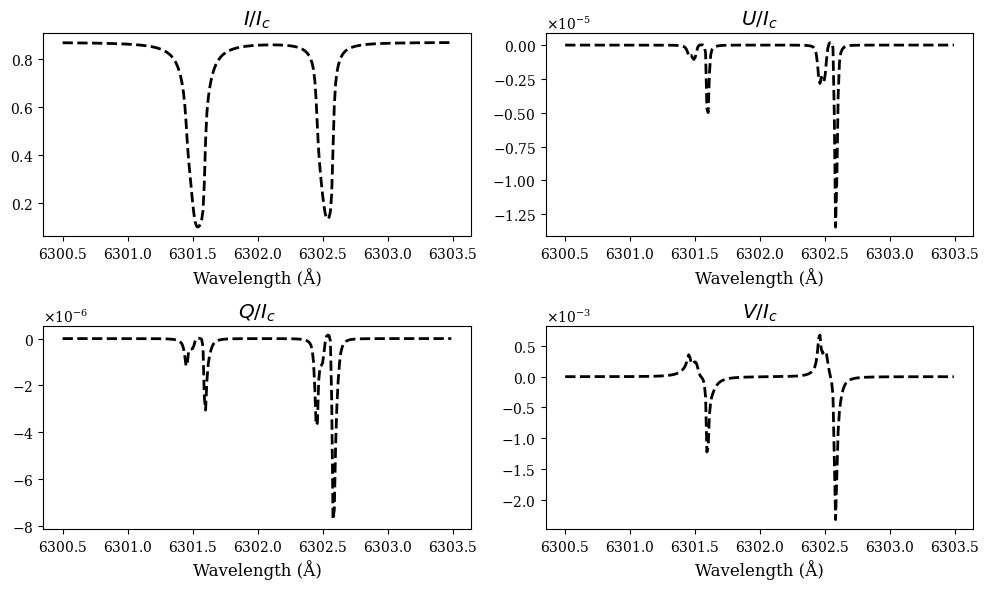

In [165]:
fig, ax = plt.subplots(2,2, figsize = (2*5,2*3))
stokes_titles = [r"$I/I_c$", r"$Q/I_c$", r"$U/I_c$", r"$V/I_c$"]
for i in range(len(stokes_titles)):
    row, column = i % 2, i // 2
    ax[row, column].plot(wl, norm_stokes[test_x, test_y, :, i], "--k")
    ax[row, column].set_title(stokes_titles[i])
    ax[row, column].set_xlabel("Wavelength (Å)")
    fig.tight_layout()
plt.show()

### 3.3 Visualize

Let's check how our spectropolarimetric data looks for the mean continuum and the polarization states, and on the pixel we defined previously.

wavelength step= 0.010 amstrongs


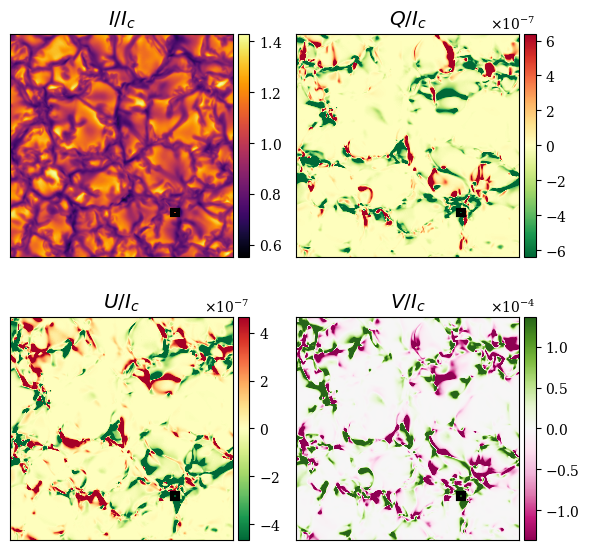

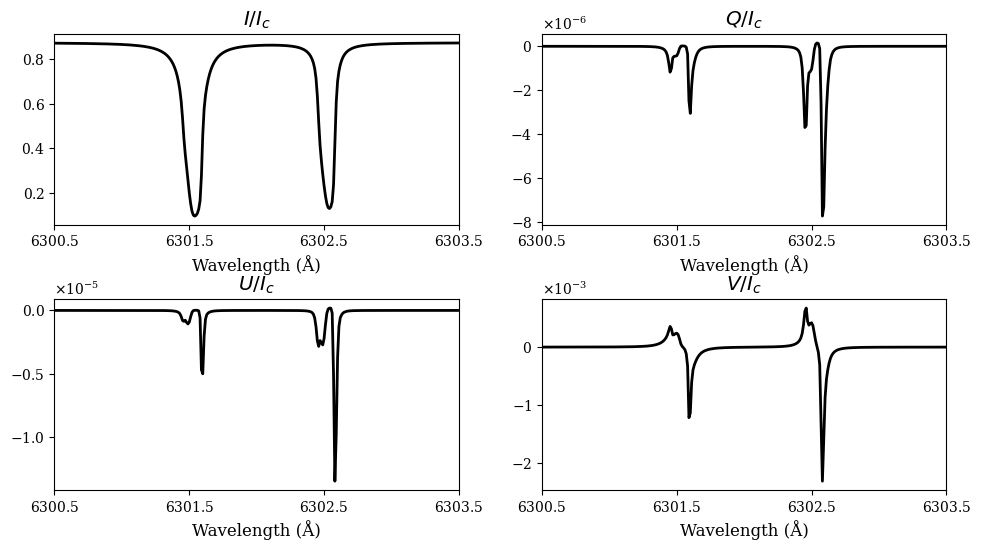

In [184]:


wl_pix = 100 #pixel in the continuum
stokes_titles = [r"$I/I_c$", r"$Q/I_c$", r"$U/I_c$", r"$V/I_c$"]
colormaps = ["inferno", "RdYlGn_r", "RdYlGn_r", "PiYG"]

# Surface plot
fig, ax = plt.subplots(2, 2, figsize=(2*3, 2*3))
norm_stokes, mean_continuum = continuum_normalization(stokes, wl)
old_mean_continuum = mean_continuum.copy()
print(r"wavelength step" + f"= {wl[1] - wl[0]:.3f} amstrongs")

for i in range(len(stokes_titles)):
    if i > 0:  # Apply restriction for Q, U, V
        data =norm_stokes[..., wl_pix, i]
        q5, q95 = np.percentile(data, [5, 95])
        vmin = -max(abs(q5), abs(q95))
        vmax = max(abs(q5), abs(q95))
    else:
        data = mean_continuum
        vmin, vmax = data.max(), data.min()
    im = ax[i // 2, i % 2].imshow(data, cmap=colormaps[i], vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(ax[i // 2, i % 2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    ax[i // 2, i % 2].set_title(stokes_titles[i])
    # Add a thick black rectangle to highlight the selected pixel
    rect = patches.Rectangle((test_y - 1.5, test_x - 1.5), 3*4, 3*4, linewidth=3, edgecolor='black', facecolor='none')
    ax[i // 2, i % 2].add_patch(rect)
    ax[i // 2, i % 2].set_xticks([])
    ax[i // 2, i % 2].set_yticks([])
fig.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "stokes_surface_plot.png", dpi=300)
plt.show()

# Spectral plot
fig, ax = plt.subplots(2, 2, figsize=(2*5, 2*2.8))
wl = np.arange(6300.5, 6303.5, 0.01)
for i in range(len(stokes_titles)):
    ax[i // 2, i % 2].plot(wl, norm_stokes[test_x, test_y,:,i], "k")
    ax[i // 2, i % 2].set_title(stokes_titles[i])
    ax[i // 2, i % 2].set_xlabel("Wavelength (Å)")
    ax[i // 2, i % 2].set_xlim(wl.min(), wl.max())
    ax[i // 2, i % 2].set_xticks([6300.5, 6301.5, 6302.5, 6303.5])
fig.tight_layout(w_pad=1.0, h_pad=0.01)
fig.savefig(images_output / "stokes_spectral_plot.pdf", dpi=300)
plt.show()



test_x: 380, test_y: 350


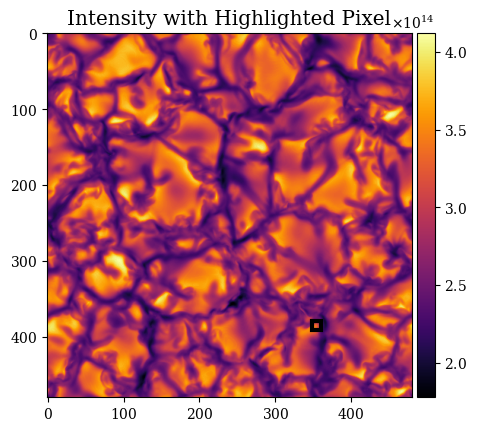

In [167]:
print(f"test_x: {test_x}, test_y: {test_y}")

fig, ax = plt.subplots(figsize=(5, 5))

# Plot the intensity (Stokes I) at the specified wavelength pixel
data = stokes[..., 0, 0]
im = ax.imshow(data, cmap='inferno')

# Add a thick black rectangle to highlight the selected pixel
rect = patches.Rectangle((test_y - 1.5, test_x - 1.5), 3*4, 3*4, linewidth=3, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

ax.set_title("Intensity with Highlighted Pixel")

plt.show()

### 3.4 Spectral sampling

In [168]:
new_points = 36
new_resol = np.linspace(0, 288, new_points, dtype=np.int64)
new_resol = np.add(new_resol, 6)
# File to save the degraded self.stokes
# Gaussian LSF kernel definition
N_kernel_points = 13  # number of points of the kernel.
def gauss(n: int = N_kernel_points, sigma: float = 1) -> np.ndarray:
    r = np.arange(-int(n / 2), int(n / 2) + 1)
    return np.exp(-r**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
g = gauss()

# Convolution
print("Degrading...")
new_stokes = np.zeros((nx, ny, new_points, stokes.shape[-1]))

for s in range(stokes.shape[-1]):
    for jx in tqdm(range(nx)):
        for jz in range(ny):
            spectrum = stokes[jx, jz, :, s]
            convolved_spectrum = convolve1d(spectrum, g, mode='constant', cval=0.0)
            new_stokes[jx, jz, :, s] = convolved_spectrum[new_resol]

new_wl = (new_resol * 0.01) + 6300.5

Degrading...


100%|██████████| 480/480 [00:01<00:00, 244.28it/s]


1974573168024.2236 1974573168024.2236


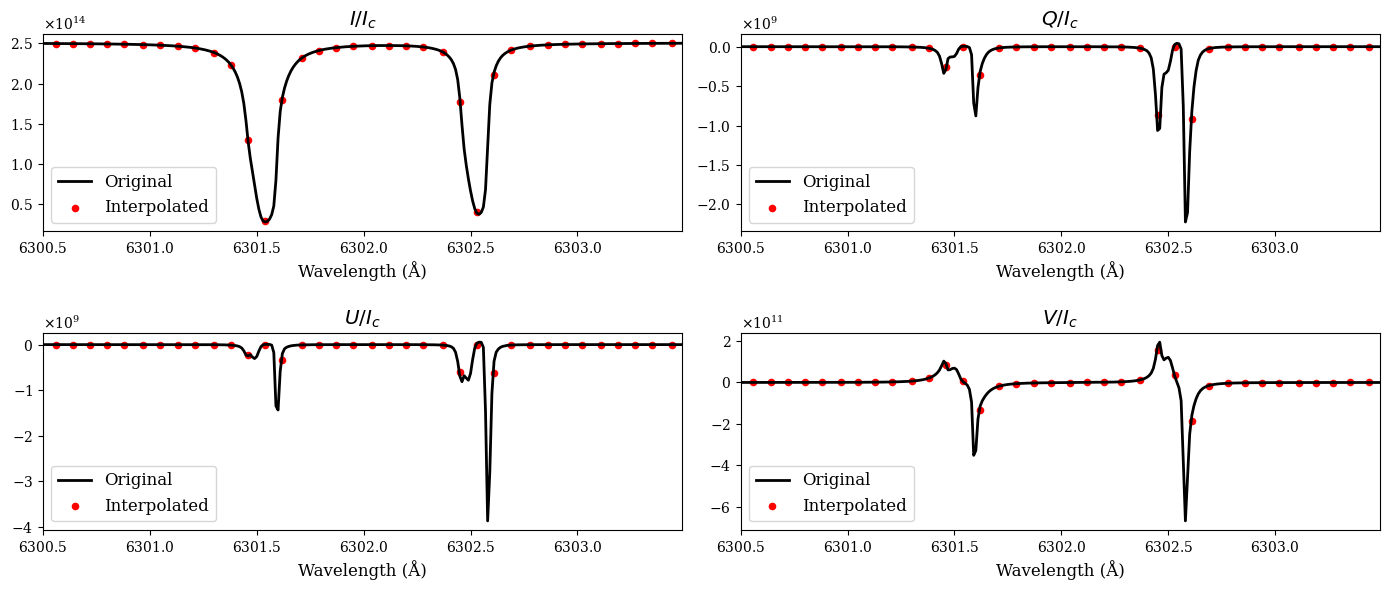

In [169]:
# Plot the previous Stokes parameters
fig, ax = plt.subplots(2, 2, figsize=(2*7, 2*3))

for i in range(len(stokes_titles)):
    ax[i // 2, i % 2].plot(wl, stokes[test_x, test_y, :, i], "k", label="Original")
    ax[i // 2, i % 2].scatter(new_wl, new_stokes[test_x, test_y, :, i], s=20, color="red", label="Interpolated")
    ax[i // 2, i % 2].set_title(stokes_titles[i])
    ax[i // 2, i % 2].set_xlabel("Wavelength (Å)")
    ax[i // 2, i % 2].set_xlim(wl.min(), wl.max())
    ax[i // 2, i % 2].legend()

fig.tight_layout(w_pad=1.0, h_pad=2)
fig.savefig(images_output / "stokes_comparison_plot.png", dpi=300)

print(new_stokes[...,3].max(), new_stokes[...,3].max())
plt.show()

## 4. Masking

### 4.1 Filtering the data by granular and intergranular zones



Granular and intergranular regions has different physicial behaviou, meaning that if we want to assess correctly the information on the calm sun we must balance the data we have over this two regions, meaning that we need to have the same amount on data on both. For this, we will apply a threshold used in computer vision for separating foreground from background over the intensity outside of the absorption lines. This parameter was selected in previous sections as the first value of the spectra over each pixel.


Text(0.5, 1.0, 'Intensity in the continuum')

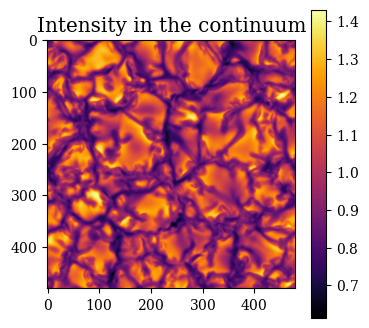

In [170]:
fig, ax = plt.subplots(figsize = (4,4))
im = ax.imshow(mean_continuum, cmap = "inferno")
fig.colorbar(im, ax = ax)
ax.set_title("Intensity in the continuum")


In [171]:
#Threshold definition
thresh_continuum = filters.threshold_otsu(mean_continuum)

#Mask extraction
mean_continuum_mask = mean_continuum > thresh_continuum
gran_mask =  np.ma.masked_array(mean_continuum, mask=mean_continuum_mask).mask
inter_mask = np.ma.masked_array(mean_continuum, mask=~mean_continuum_mask).mask

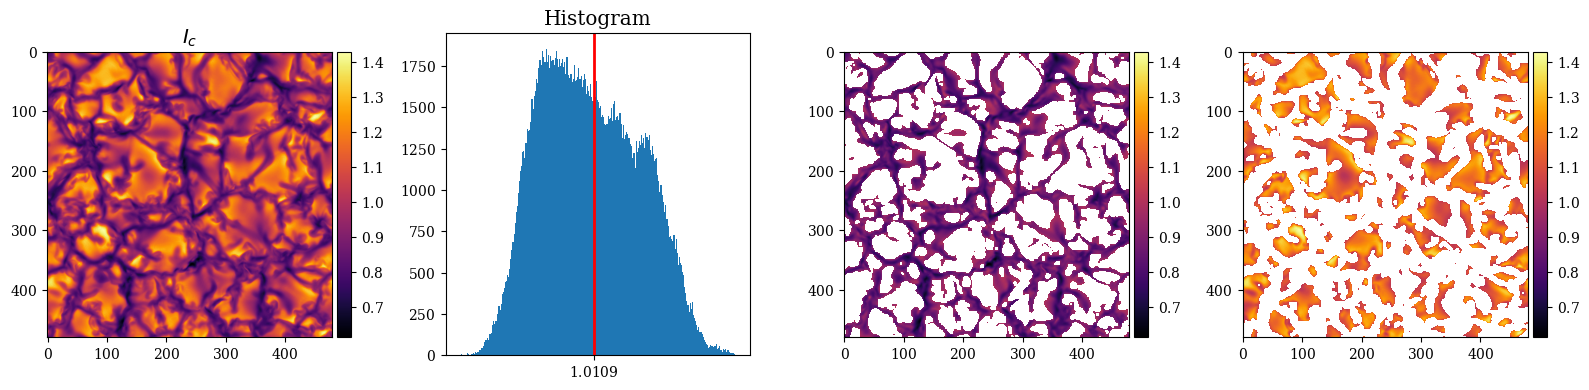

In [172]:


fig, ax = plt.subplots(1, 4, figsize=(4*4, 4))

cmap = "inferno"
im = ax[0].imshow(mean_continuum, cmap=cmap)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)
vmin, vmax = [np.min(mean_continuum), np.max(mean_continuum)]
ax[0].set_title(r"$I_{c}$")

ax[1].hist(mean_continuum.ravel(), bins=256)
ax[1].set_xticks([thresh_continuum])
ax[1].set_title('Histogram')
ax[1].axvline(thresh_continuum, color='r')

im2 = ax[2].imshow(np.ma.masked_array(mean_continuum, mask=mean_continuum_mask), vmin=vmin, vmax=vmax, cmap=cmap)
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

im3 = ax[3].imshow(np.ma.masked_array(mean_continuum, mask=~mean_continuum_mask), vmin=vmin, vmax=vmax, cmap=cmap)
divider3 = make_axes_locatable(ax[3])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax3)

fig.tight_layout()
fig.savefig(images_output / "Otsu_thres_I_stokes.png", transparent=False)
plt.show()



### 4.2 Masking atm data

In [173]:
#Mask application
muram_box_gran = muram_box[gran_mask]
muram_box_inter = muram_box[inter_mask]
stokes_gran = stokes[gran_mask]
stokes_inter = stokes[inter_mask]
len_inter = muram_box_inter.shape[0]
len_gran = muram_box_gran.shape[0]


In [174]:
muram_box_gran.shape, muram_box_inter.shape, stokes_gran.shape, stokes_inter.shape

((104048, 20, 6), (126352, 20, 6), (104048, 300, 4), (126352, 300, 4))

In [175]:
#leveraging the quantity of data from the granular and intergranular zones by a random dropping of elements of the greater zone.
print("leveraging...")
index_select  = []
np.random.seed(50)
if len_inter < len_gran:
    index_select = np.random.choice(range(len_gran), size = (len_inter,), replace = False)
    muram_box_leveraged = np.concatenate((muram_box_gran[index_select], muram_box_inter), axis = 0)
    stokes_leveraged = np.concatenate((stokes_gran[index_select], stokes_inter), axis = 0)
elif len_inter > len_gran:
    index_select = np.random.choice(range(len_inter), size = (len_gran,), replace = False)
    muram_box_leveraged = np.concatenate((muram_box_gran, muram_box_inter[index_select]), axis = 0)
    stokes_leveraged = np.concatenate((stokes_gran, stokes_inter[index_select]), axis = 0)
print("Done")

leveraging...
Done


In [176]:
muram_box_leveraged.shape, stokes_leveraged.shape

((208096, 20, 6), (208096, 300, 4))